# Q-Reply @ Qhack 2021

Scope of the project is to develop a variational classifier to answer the following:
* Do we find a quantum advantage (higher accuracy) on some real-life dataset (no artificially generated data)?
* Are we happy already today with the fidelity of gates or do we need to wait years also for variational approaches? In other words, does the run on quantum hardware resembles the run on simulator? Does noise lead to worse or completely different solutions?

The data we use is taken from:<br>
CINAR, I. and KOKLU, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194.<br>
DOI: https://doi.org/10.18201/ijisae.2019355381

# Let's look at the data

The dataset contains 7 numerical features for 2 different types of rice grains ("Cammeo" and "Osmancik").

For visualization purposes and for making some initial experiments, we reduce the number of features to 2 using Principal Component Analysis (https://en.wikipedia.org/wiki/Principal_component_analysis).

We plot the dataset below.

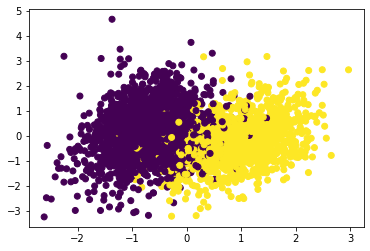

In [1]:
import data_loader as dl
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


n_components = 2
pca_train_df, pca_test_df = dl.load_train_test_pca(n_components)
plt.scatter(
    x=pca_train_df["pca_1"],
    y=pca_train_df["pca_2"],
    c=pca_train_df["label"]
)
plt.show()

Even when only using only 2 principal components, the separation between the two classes is evident. Classification with classical methods (using all 7 features) reaches an accuracy of over 90%.

## Classical benchmark

Accuracy on test set = 92%

In [2]:
max_value = np.max(abs(pca_train_df.values))
plot_range = 3

pca_train_df.iloc[:,:-1] = pca_train_df.iloc[:,:-1] * plot_range / max_value
pca_test_df.iloc[:,:-1] = pca_test_df.iloc[:,:-1] * plot_range / max_value

train_coordinates = pca_train_df.iloc[:,:-1].values.reshape(-1, 1, n_components)
train_labels = pca_train_df.label
test_coordinates = pca_test_df.iloc[:,:-1].values.reshape(-1, 1, n_components)
test_labels = pca_test_df.label

In [3]:
X_train = train_coordinates.reshape(-1, n_components)
X_test = test_coordinates.reshape(-1, n_components)
y_train = train_labels
y_test = test_labels

clf = svm.SVC()
clf.fit(X_train, y_train)
 
pred_classic = clf.predict(X_train)
print(confusion_matrix(y_true=train_labels, y_pred=pred_classic))
print(classification_report(y_true=train_labels, y_pred=pred_classic))

pred_classic = clf.predict(X_test)
print(confusion_matrix(y_true=test_labels, y_pred=pred_classic))
print(classification_report(y_true=test_labels, y_pred=pred_classic))

[[1621  107]
 [ 119 1201]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1728
           1       0.92      0.91      0.91      1320

    accuracy                           0.93      3048
   macro avg       0.92      0.92      0.92      3048
weighted avg       0.93      0.93      0.93      3048

[[420  32]
 [ 31 279]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       452
           1       0.90      0.90      0.90       310

    accuracy                           0.92       762
   macro avg       0.91      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762



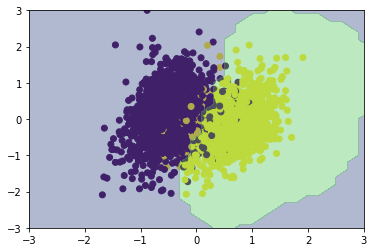

In [4]:
grid_size = 30
x_range = [2 * plot_range * j / grid_size for j in range(-grid_size // 2, grid_size // 2 + 1, 1)]
y_range = x_range
grid_data = np.array([[j, k] for j in x_range for k in y_range])
predictions = clf.predict(grid_data)
pred_labels = 1 * (np.array(predictions) > 0.5)

plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
plt.contourf(x_range, y_range, pred_labels.reshape(grid_size + 1, grid_size + 1).T, levels=[-0.1, 0.5, 1.1], alpha=0.4)
plt.show()

# How good can a variational quantum classifier perform?

We train circuit as following

* The 2 features are encoded in 2 qubits using the BasicEntanglerLayers
* StornglyEntanglingLayers are used with variational parameters that are learned
* The expectation value of PauliZ is measured on the first qubit
* The measurement value is rescaled to the range \[0, 1\] to match the labels
* A loss is introduced to compare the circuit output to the labels

## Effects on the performance

The following elements greatly affect the result of the circuit

* Operations in the circuit (e.g. only X rotations don't introduce much entanglement)
* Postprocessing and loss function (e.g. linear transformation + squareloss; sigmoid + logloss)
* Feature scaling (this affect the periodicity of the decision boundaries)

Because data is loaded into the quantum circuit as rotation angles, one has to be careful with the scale of the features. Suppose that a datapoint is described by the two features $(x, y)$. If $x$ is loaded in the circuit as angle in a single qubit rotation $U(x)$, any value $x + 2 n \pi$ (where $n$ is a natural number) will be indistinguishable from $x$. In other words $U(x) = U(x + 2 n \pi)$. Therefore the circuit can only learn periodic boundary decisions and this period should match the scale of the dataset (or any natural periodicity present in the dataset).

| Boundary decisions learned by circuit. | Boundary decisions learned by same circuit with features rescaled by a factor 2. | Boundary decisions learned by same circuit with features rescaled by a factor 3. |
| :---: | :---: | :---: |
| 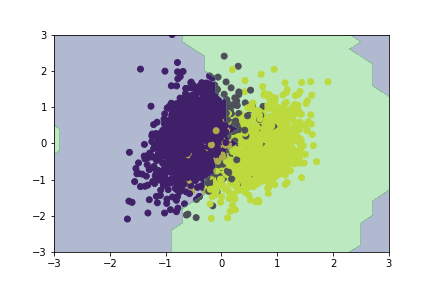 | 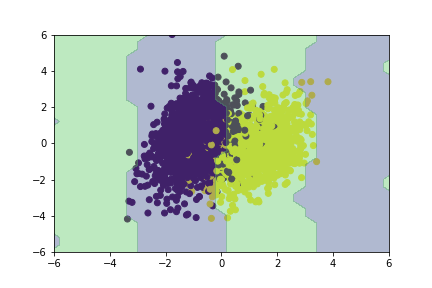 | 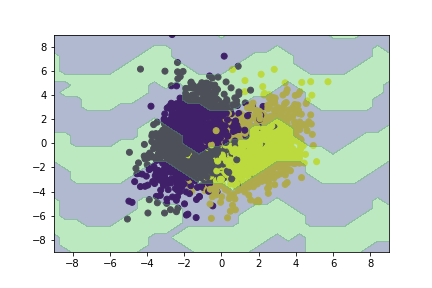 |
| In this case the periodicity of the model can accomodate well the natural scale of the dataset | In this case the periodicity of the model barely matches the natural scale of the dataset | In this case the periodicity of the model cannot match the natural scale of the dataset |
| Accuracy on test set: 89% | Accuracy on test set: 88% | Accuracy on test set: 63% |